In [1]:
# ------------------------------------------------------------------------
#
# TITLE - process_data.ipynb
# PROJECT - mw_dfs
#
# ------------------------------------------------------------------------
#
# Docstrings and metadata:
'''Process the Gaia and APOGEE data, then divide the sample into
thin disk, thick disk, and halo subsamples

colormaps
'''

__author__ = "James Lane"

In [2]:
### Imports
import numpy as np
import os, sys
import dill as pickle
from matplotlib import pyplot as plt
from matplotlib import patches
from galpy import potential
from galpy import orbit
from galpy import actionAngle as aA

# galpy scales
ro = 8.178 # Gravity+ 2019
vo = 220 # MWPotential2014
zo = 0.0208 # Bennet+ 2019

sys.path.insert(0,'../../src/')
from mw_dfs import plot as project_plot
project_colors = project_plot.colors()
# Better rainbow colormap
rainbow_cmap = project_colors.colourmap('rainbow')

In [3]:
### Notebook setup
%matplotlib inline
plt.style.use('../../src/mpl/project.mplstyle')
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

In [4]:
### Potential
mwpot = potential.MWPotential2014
phi0 = potential.evaluatePotentials(mwpot,1e10,0)

In [5]:
### Pathing
data_dir = '/geir_data/scr/lane/projects/mw-dfs/data/data_Sept_2021/gaia_apogee/'
out_dir = '/geir_data/scr/lane/projects/mw-dfs/data/data_Sept_2021/gaia_apogee_processed/'

In [ ]:
### Functions for dealing with lines

# Get line parameters from pairs of points
def get_params_from_line(xs,ys):
    m = (ys[1]-ys[0])/(xs[1]-xs[0])
    b = ys[0] - m*xs[0]
    return m,b
#def

# Line equation function
def line_equation(x,m,b):
    return m*x + b
#def

## Load data

In [6]:
### APOGEE
RESULTS_VERS = 'l33'
# allstar_filename = data_dir+'allstar_'+RESULTS_VERS+'.npy'
allstar_filename = data_dir+'allstar.npy'


print('\nLoading APOGEE data from '+allstar_filename)
allstar = np.load(allstar_filename)
print(str(len(allstar))+' stars in total sample')


Loading APOGEE data from /geir_data/scr/lane/projects/mw-dfs/data/data_Sept_2021/gaia_apogee/allstar.npy
261012 stars in total sample


In [7]:
### Statistical Sample
statIndx_filename = data_dir+'statIndx_'+RESULTS_VERS+'.npy'

print('\nLoading APOGEE statistical sample from '+statIndx_filename)
statIndx = np.load(statIndx_filename)
print(str(np.sum(statIndx))+' stars in satistical sample')


Loading APOGEE statistical sample from /geir_data/scr/lane/projects/mw-dfs/data/data_Sept_2021/gaia_apogee/statIndx_l33.npy
196058 stars in satistical sample


In [8]:
### Gaia data and APOGEE match index

# Filenames
gaia2_data_filename = data_dir+'GDR2_'+RESULTS_VERS+'_data.npy'
apogee_matches_filename = data_dir+'GDR2_'+RESULTS_VERS+'_apogee_matches.npy'

print('Loading Gaia DR2 catalog from '+gaia2_data_filename)
gaia2_data = np.load(gaia2_data_filename, allow_pickle=True)
print('Loading Gaia DR2 - APOGEE matches from '+apogee_matches_filename)
matches_indx = np.load(apogee_matches_filename)

Loading Gaia DR2 catalog from /geir_data/scr/lane/projects/mw-dfs/data/data_Sept_2021/gaia_apogee/GDR2_l33_data.npy
Loading Gaia DR2 - APOGEE matches from /geir_data/scr/lane/projects/mw-dfs/data/data_Sept_2021/gaia_apogee/GDR2_l33_apogee_matches.npy


In [9]:
# index APOGEE allstar to Gaia DR2 and apply the statistical sample index
allstar_gaia = allstar[statIndx][matches_indx]

## Clean data and make kinematics
The Staeckel deltas and eccentricities may take awhile

In [10]:
# Should have defined 6D kinematics for eccentricities
input_mask = np.isfinite(gaia2_data['RA']) &\
             np.isfinite(gaia2_data['DEC']) &\
             np.isfinite(gaia2_data['pmra']) &\
             np.isfinite(gaia2_data['pmdec']) &\
             np.isfinite(allstar_gaia['weighted_dist']) &\
             np.isfinite(allstar_gaia['VHELIO_AVG'])

allstar_input = allstar_gaia[input_mask]
gaia2_input = gaia2_data[input_mask]

In [11]:
# Make coordinate array for orbit creation
vxvv = np.array([gaia2_input['RA'],
                 gaia2_input['DEC'],
                 allstar_input['weighted_dist']/1000,
                 gaia2_input['pmra'],
                 gaia2_input['pmdec'],
                 allstar_input['VHELIO_AVG']
                 ]).T
orbs_input = orbit.Orbit(vxvv=vxvv, radec=True, ro=ro, vo=vo, zo=zo)

In [18]:
# Force the calculation of new eccentricities even if stashed ones exist?
force_eccs = False
ecc_deltas_filename = out_dir+'ecc_deltas_input.npy'

# Eccentricities are stashed because they take some time to compute
if force_eccs or not os.path.exists(ecc_deltas_filename):
    aAS = aA.actionAngleStaeckel(pot=mwpot, delta=0.4, ro=ro, vo=vo, zo=zo)
    print('Calculating Staeckel deltas...')
    deltas_input = aA.estimateDeltaStaeckel(mwpot, orbs_input.R(), orbs_input.z(), no_median=True)
    print('Calculating eccentricities...')
    ecc_input,_,_,_ = aAS.EccZmaxRperiRap(orbs_input, delta=deltas_input, 
                                          use_physical=True, c=True)
    try:
        deltas_input = deltas_input.value
    except AttributeError:
        pass
    try:
        ecc_input = ecc_input.value
    except AttributeError:
        pass
    print('Saving eccentricities and deltas to '+ecc_deltas_filename)
    np.save(ecc_deltas_filename,np.array([ecc_input,deltas_input]))
else:
    print('Loading eccentricities and deltas from '+ecc_deltas_filename)
    ecc_input,deltas_input = np.load(ecc_deltas_filename)
##fi

Loading eccentricities and deltas from /geir_data/scr/lane/projects/mw-dfs/data/data_Sept_2021/gaia_apogee_processed/ecc_deltas_input.npy


# Extract the main sample for Lane+ 2021

In [19]:
# Cut bulge fields. Within 20 degrees of the galactic center
omask_bulge = ~(((allstar_input['GLON'] > 340.) | (allstar_input['GLON'] < 20.)) &\
                (np.fabs(allstar_input['GLAT']) < 20.)
               )

# Cut high fractional distance uncertainty, undefined eccentricity, undefined alpha/Fe, 
# undefined Fe, high log(g) uncertainty
omask_quality = ((allstar_input['weighted_dist_error']/allstar_input['weighted_dist'] < 0.2) &\
                 (np.isfinite(ecc_input)) &\
                 (allstar_input['MG_FE'] > -9999) &\
                 (allstar_input['FE_H'] > -9999) &\
                 (allstar_input['LOGG_ERR'] < 0.1)
                )

# Cut globular cluster fields
allstar_input_locid = allstar_input['LOCATION_ID'] # Prevents unneccesary querying
omask_gc = ((allstar_input_locid != 2011) &\
            (allstar_input_locid != 4353) &\
            (allstar_input_locid != 5093) &\
            (allstar_input_locid != 5229) &\
            (allstar_input_locid != 5294) &\
            (allstar_input_locid != 5295) &\
            (allstar_input_locid != 5296) &\
            (allstar_input_locid != 5297) &\
            (allstar_input_locid != 5298) &\
            (allstar_input_locid != 5299) &\
            (allstar_input_locid != 5300) &\
            (allstar_input_locid != 5325) &\
            (allstar_input_locid != 5328) &\
            (allstar_input_locid != 5329) &\
            (allstar_input_locid != 5438) &\
            (allstar_input_locid != 5528) &\
            (allstar_input_locid != 5529) &\
            (allstar_input_locid != 5744) &\
            (allstar_input_locid != 5801)
           )

# Combine masks
omask = omask_bulge & omask_quality & omask_gc

# Apply to data
gaia2_omask = gaia2_input[omask]
allstar_omask = allstar_input[omask]
orbs_omask = orbs_input[omask]
ecc_omask = ecc_input[omask]
print('Number of good stars: '+str(len(orbs_omask)))

Number of good stars: 150620


/usr/local/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "



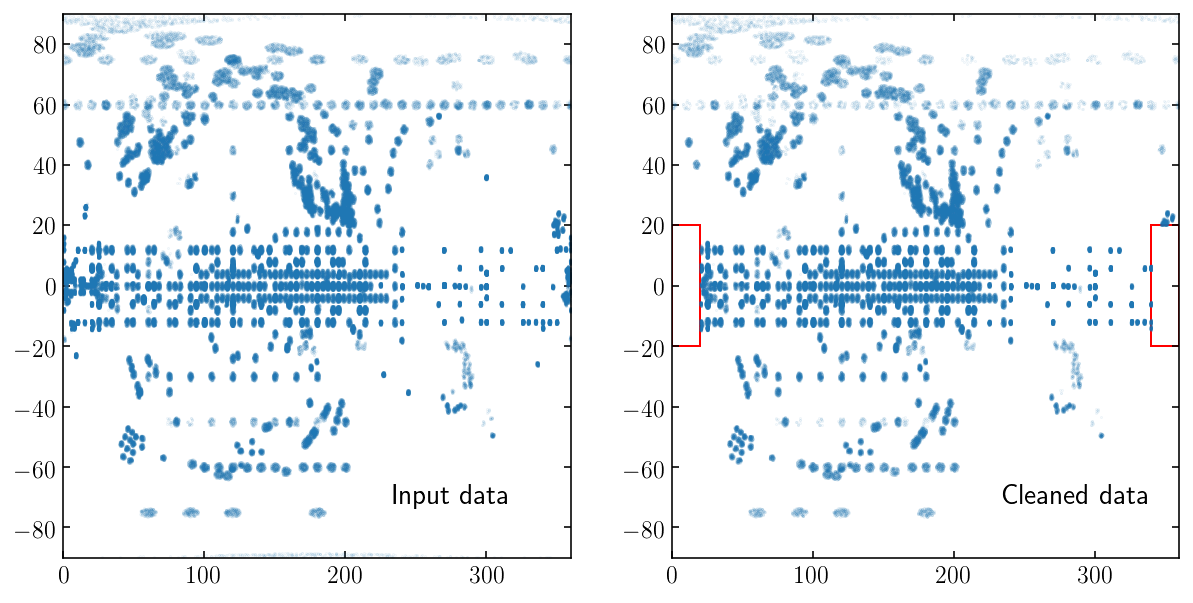

In [20]:
# Plot the input and masked data
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.scatter( allstar_input['GLON'], allstar_input['GLAT'], alpha=0.1, s=0.1, zorder=2 )
ax2.scatter( allstar_omask['GLON'], allstar_omask['GLAT'], alpha=0.1, s=0.1, zorder=2 )

l_lon_patch = patches.Rectangle(xy=(0,-20), width=20, height=40, 
                                           edgecolor='Red', facecolor='None', zorder=1)
r_lon_patch = patches.Rectangle(xy=(340,-20), width=20, height=40, 
                                           edgecolor='Red', facecolor='None', zorder=1)
ax2.add_artist(l_lon_patch)
ax2.add_artist(r_lon_patch)
ax1.annotate('Input data', xy=(0.65,0.1), xycoords='axes fraction', fontsize=14)
ax2.annotate('Cleaned data', xy=(0.65,0.1), xycoords='axes fraction', fontsize=14)

ax1.set_xlim(0,360)
ax1.set_ylim(-90,90)
ax2.set_xlim(0,360)
ax2.set_ylim(-90,90)

fig.show()

## Differentiate stars by metallicity

In [22]:
### Boundaries between thin/thick disk, halo in metallicity space

# Points that define lines
halo_x = [-1.2,-0.9]
halo_y = [0.5,-0.2]
disk_x = [-1.0,0.5]
disk_y = [0.25,0.08]

/usr/local/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "



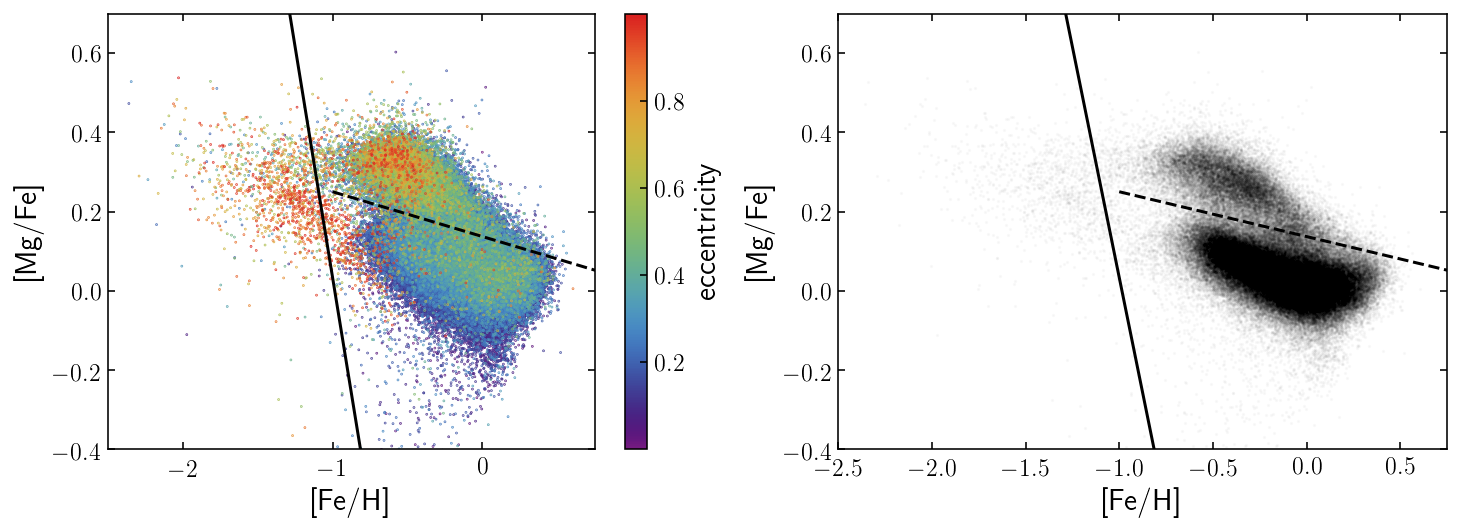

In [30]:
### Plot the metallicities

fig = plt.figure(figsize=(12,4))
axs = fig.subplots(nrows=1, ncols=2)

xlim = (-2.5,1.0)
ylim = (-0.5,0.7)

# Plot 1 - color by eccentricity
ecc_sort = np.argsort(ecc_omask)
pts = axs[0].scatter(allstar_omask['FE_H'][ecc_sort], allstar_omask['MG_FE'][ecc_sort], s=0.1, alpha=1, 
                 c=ecc_omask[ecc_sort], cmap=rainbow_cmap, rasterized=True)
cbar = fig.colorbar(pts, ax=axs[0])
cbar.set_label('eccentricity')

# Plot 2 - low-alpha scatter to see density
axs[1].scatter(allstar_omask['FE_H'], allstar_omask['MG_FE'], s=0.5, alpha=0.025, color='Black', rasterized=True)

m_halo, b_halo = get_params_from_line(halo_x, halo_y)
m_disk, b_disk = get_params_from_line(disk_x, disk_y)
disk_x_start = disk_x[0]

for i in range(len(axs)):
    axs[i].set_xlabel(r'[Fe/H]')
    axs[i].set_ylabel(r'[Mg/Fe]')
    axs[i].set_ylim(-0.4,0.7)
    axs[i].set_xlim(-2.5,0.75)
    
    plot_halo_x = np.linspace(xlim[0],xlim[1],2)
    plot_halo_y = line_equation(plot_halo_x, m_halo, b_halo)
    plot_disk_x = np.linspace(disk_x_start,xlim[1],2)
    plot_disk_y = line_equation(plot_disk_x, m_disk, b_disk)
    
    axs[i].plot(plot_halo_x, plot_halo_y, color='Black', linestyle='solid')
    axs[i].plot(plot_disk_x, plot_disk_y, color='Black', linestyle='dashed')
###i

fig.show()

/usr/local/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "

2198 halo stars
124879 thin disk stars
23543 thick disk stars
150620 Total
150620 In omask


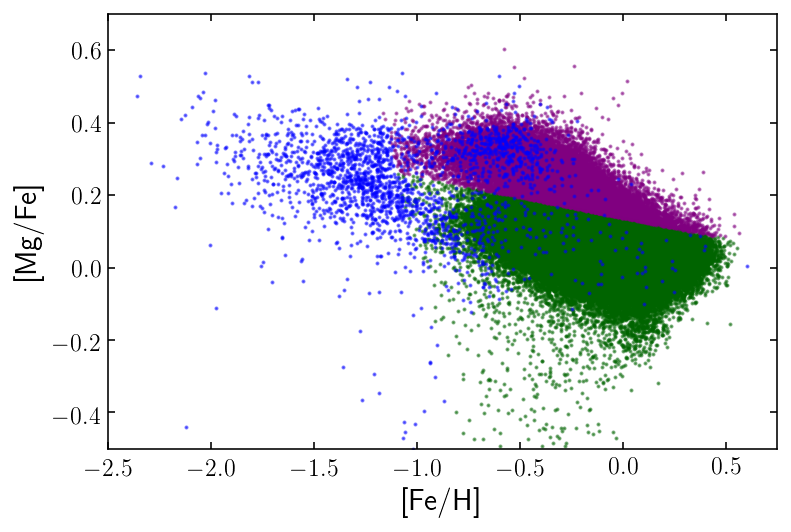

In [24]:
### Separate the stars into thin disk, thick disk, halo

# Alpha/Fe of points on the separation lines
halo_line_alphas = line_equation( allstar_omask['FE_H'], m_halo, b_halo )
disk_line_alphas = line_equation( allstar_omask['FE_H'], m_disk, b_disk )

# Stars with |velocity| > local circular velocity are classified as halo
vcirc_omask = potential.vcirc(mwpot, orbs_omask.R(), 0)*vo
vmag_omask = np.sqrt( orbs_omask.vR().value**2 +\
                     (orbs_omask.vT().value-vcirc_omask)**2 +\
                      orbs_omask.vz().value**2 )

# Separate stars
where_halo  = np.where( np.logical_or((allstar_omask['MG_FE'] < halo_line_alphas),
                                      (vmag_omask > vcirc_omask)
                                      )
                       )[0]
where_thin  = np.where( (allstar_omask['MG_FE'] > halo_line_alphas) &\
                        (allstar_omask['MG_FE'] < disk_line_alphas) &\
                        (vmag_omask < vcirc_omask)
                       )[0]
where_thick = np.where( (allstar_omask['MG_FE'] > halo_line_alphas) &\
                        (allstar_omask['MG_FE'] > disk_line_alphas) &\
                        (vmag_omask < vcirc_omask)
                       )[0]

# Plot
fig = plt.figure()
ax = fig.add_subplot(111)

ax.scatter(allstar_omask['FE_H'][where_thin], allstar_omask['MG_FE'][where_thin], 
           s=1, alpha=0.5, color='DarkGreen', label='Thin Disk')
ax.scatter(allstar_omask['FE_H'][where_thick], allstar_omask['MG_FE'][where_thick],
           s=1, alpha=0.5, color='Purple', label='Thick Disk')
ax.scatter(allstar_omask['FE_H'][where_halo], allstar_omask['MG_FE'][where_halo], 
           s=1, alpha=0.5, color='Blue', label='Halo')

ax.set_xlabel(r'[Fe/H]')
ax.set_ylabel(r'[Mg/Fe]')
ax.set_ylim(-0.5,0.7)
ax.set_xlim(-2.5,0.75)
fig.show()

print(str(len(where_halo))+' halo stars')
print(str(len(where_thin))+' thin disk stars')
print(str(len(where_thick))+' thick disk stars')

## Save

In [26]:
# Only save a subset of the Gaia and APOGEE data fields to cut down on 
# disk space usage.
gaia2_save_fields = np.append( gaia2_omask.dtype.names[:26], 
                              np.array(['radial_velocity','radial_velocity_error']) )
allstar_save_fields = np.concatenate( (allstar_omask.dtype.names[:7],
                                       np.array(['VHELIO_AVG','VERR']), 
                                       allstar_omask.dtype.names[97:149], 
                                       allstar_omask.dtype.names[226:]
                                      ))

In [27]:
gaia2_halo = gaia2_omask[where_halo]
gaia2_thin = gaia2_omask[where_thin]
gaia2_thick = gaia2_omask[where_thick]

allstar_halo = allstar_omask[where_halo]
allstar_thin = allstar_omask[where_thin]
allstar_thick = allstar_omask[where_thick]

os_halo = orbs_omask[where_halo]
os_thin = orbs_omask[where_thin]
os_thick = orbs_omask[where_thick]

np.save(out_dir+'ecc_all',ecc_omask)
np.save(out_dir+'gaia_data_all',gaia2_halo[gaia2_save_fields])
np.save(out_dir+'allstar_all',allstar_omask[allstar_save_fields])
with open(out_dir+'orbits_all.pkl','wb') as f:
    pickle.dump(orbs_omask, f)
##wi

np.save(out_dir+'gaia_data_halo',gaia2_halo[gaia2_save_fields])
np.save(out_dir+'allstar_halo',allstar_halo[allstar_save_fields])
with open(out_dir+'orbits_halo.pkl','wb') as f:
    pickle.dump(os_halo, f)
##wi

np.save(out_dir+'gaia_data_thin',gaia2_thin[gaia2_save_fields])
np.save(out_dir+'allstar_thin',allstar_thin[allstar_save_fields])
with open(out_dir+'orbits_thin.pkl','wb') as f:
    pickle.dump(os_thin, f)
##wi

np.save(out_dir+'gaia_data_thick',gaia2_thick[gaia2_save_fields])
np.save(out_dir+'allstar_thick',allstar_thick[allstar_save_fields])
with open(out_dir+'orbits_thick.pkl','wb') as f:
    pickle.dump(os_thick, f)
##wi

# Now do this again but for the added Inner-Galaxy sample (only for Lane+ 2021 paper)

In [32]:
# Now only choose bulge fields. Within 20 degrees of the galactic center, 
# but outside of 3kpc so things aren't dominated by bulge stars.
omask_bulge = (((allstar_input['GLON'] > 340.) | (allstar_input['GLON'] < 20.)) &\
                (np.fabs(allstar_input['GLAT']) < 20.)
               )

omask_dist = orbs_input.r().value > 3

omask = omask_bulge & omask_dist & omask_quality & omask_gc

gaia2_omask_ig = gaia2_input[omask]
allstar_omask_ig = allstar_input[omask]
orbs_omask_ig = orbs_input[omask]
ecc_omask_ig = ecc_input[omask]

print('Number of good stars: '+str(len(orbs_omask_ig)))

Number of good stars: 9408


/usr/local/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "



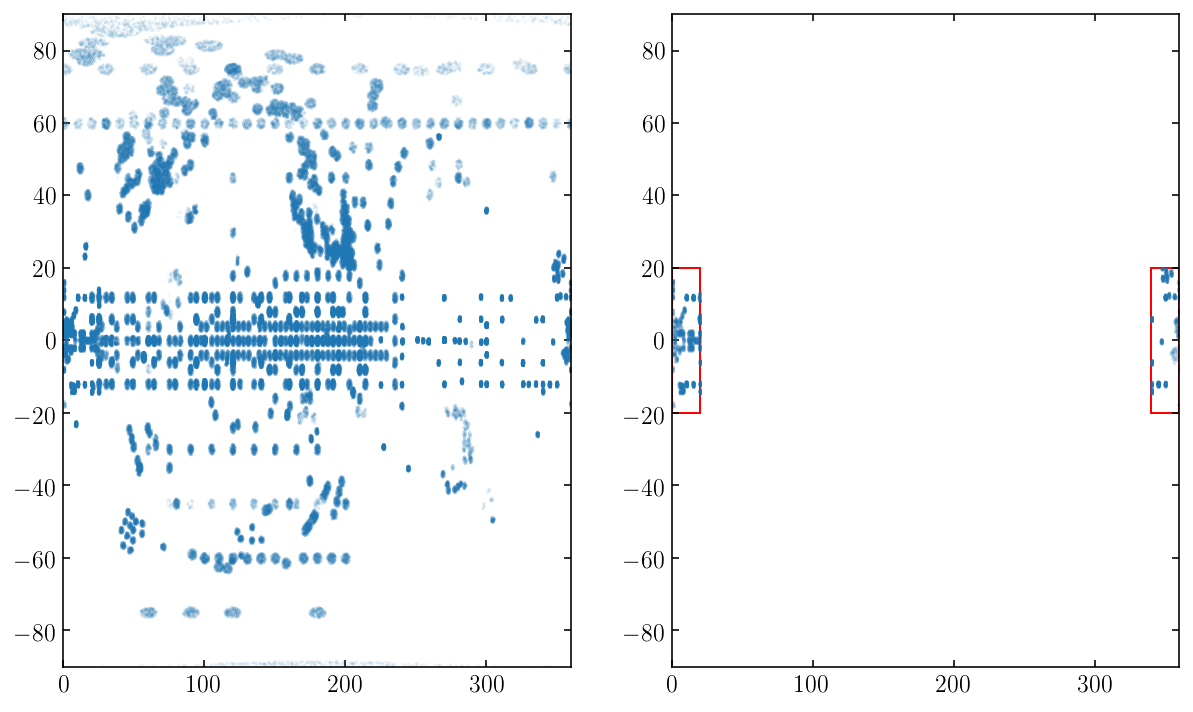

In [34]:
fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.scatter( allstar_input['GLON'], allstar_input['GLAT'], alpha=0.1, s=0.1, zorder=2 )
ax2.scatter( allstar_omask_ig['GLON'], allstar_omask_ig['GLAT'], alpha=0.1, s=0.1, zorder=2 )

l_lon_patch = patches.Rectangle(xy=(0,-20), width=20, height=40, 
                                           edgecolor='Red', facecolor='None', zorder=1)
r_lon_patch = patches.Rectangle(xy=(340,-20), width=20, height=40, 
                                           edgecolor='Red', facecolor='None', zorder=1)
ax2.add_artist(l_lon_patch)
ax2.add_artist(r_lon_patch)

ax1.set_xlim(0,360)
ax1.set_ylim(-90,90)

ax2.set_xlim(0,360)
ax2.set_ylim(-90,90)

fig.show()

## Differentiate stars by metallicity

/usr/local/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "



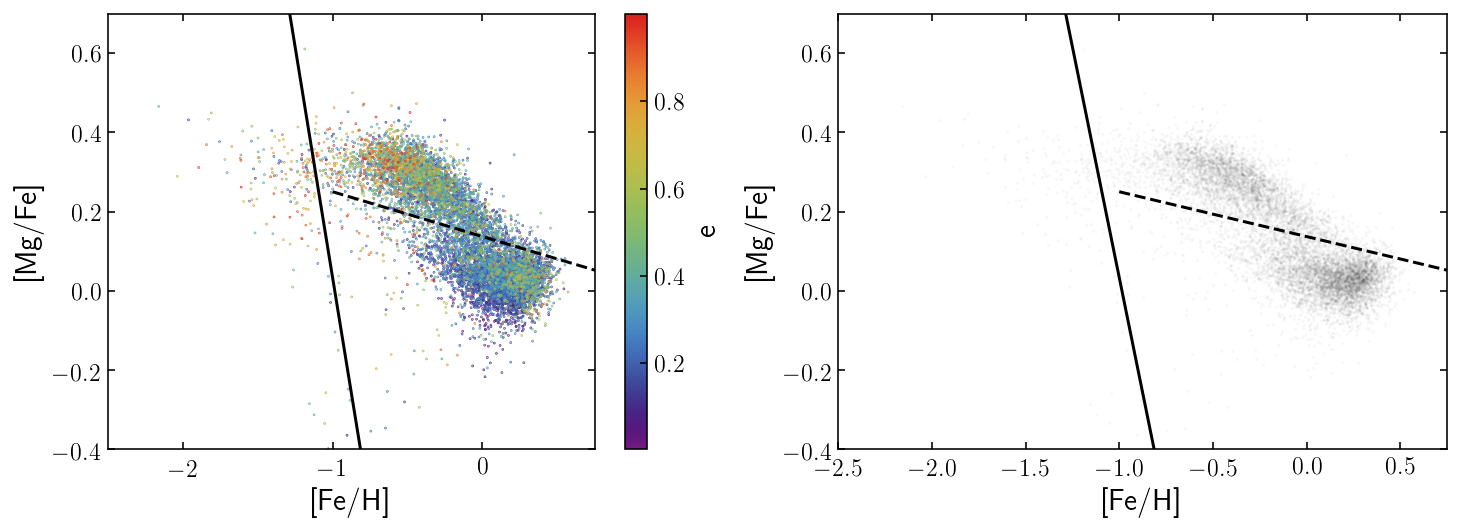

In [35]:
fig = plt.figure(figsize=(12,4))
axs = fig.subplots(nrows=1, ncols=2)

xlim = (-2.5,1.0)
ylim = (-0.5,0.7)

# Plot 1 - eccentricity
ecc_sort = np.argsort(ecc_omask_ig)
pts = axs[0].scatter(allstar_omask_ig['FE_H'][ecc_sort], allstar_omask_ig['MG_FE'][ecc_sort], s=0.1, alpha=1, 
                 c=ecc_omask_ig[ecc_sort], cmap=rainbow_cmap, rasterized=True)
cbar = fig.colorbar(pts, ax=axs[0])
cbar.set_label('e')

# Plot 2 - low-alpha scatter to see density
axs[1].scatter(allstar_omask_ig['FE_H'], allstar_omask_ig['MG_FE'], s=0.5, alpha=0.025, color='Black', rasterized=True)

# Lines that 
halo_x = [-1.2,-0.9]
halo_y = [0.5,-0.2]
disk_x = [-1.0,0.5]  # = [-1.0,0.2,0.5]
disk_y = [0.25,0.08] # = [0.2,0.05,0.05]

m_halo, b_halo = get_params_from_line(halo_x, halo_y)
m_disk, b_disk = get_params_from_line(disk_x, disk_y)
disk_x_start = disk_x[0]

for i in range(len(axs)):
    axs[i].set_xlabel(r'[Fe/H]')
    axs[i].set_ylabel(r'[Mg/Fe]')
    axs[i].set_ylim(-0.4,0.7)
    axs[i].set_xlim(-2.5,0.75)
    
    plot_halo_x = np.linspace(xlim[0],xlim[1],2)
    plot_halo_y = line_equation(plot_halo_x, m_halo, b_halo)
    plot_disk_x = np.linspace(disk_x_start,xlim[1],2)
    plot_disk_y = line_equation(plot_disk_x, m_disk, b_disk)
    
    axs[i].plot(plot_halo_x, plot_halo_y, color='Black', linestyle='solid')
    axs[i].plot(plot_disk_x, plot_disk_y, color='Black', linestyle='dashed')

fig.show()

/usr/local/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "

497 halo stars
5179 thin disk stars
3732 thick disk stars


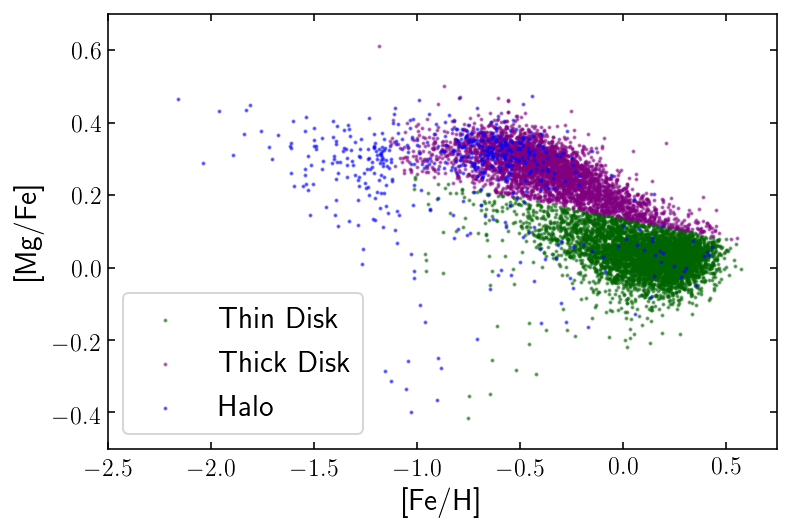

In [36]:
# Separate the stars into the three groups:

halo_line_alphas = line_equation( allstar_omask_ig['FE_H'], m_halo, b_halo )
disk_line_alphas = line_equation( allstar_omask_ig['FE_H'], m_disk, b_disk )

vcirc_omask_ig = potential.vcirc(mwpot, orbs_omask_ig.R(), 0)*vo
vmag_omask_ig = np.sqrt( orbs_omask_ig.vR().value**2 +\
                     (orbs_omask_ig.vT().value-vcirc_omask_ig)**2 +\
                      orbs_omask_ig.vz().value**2 )

where_halo  = np.where( np.logical_or((allstar_omask_ig['MG_FE'] < halo_line_alphas),
                                      (vmag_omask_ig > vcirc_omask_ig)
                                      #(allstar_omask_ig['MG_FE'] > halo_line_alphas) &\
                                      #(allstar_omask_ig['MG_FE'] < disk_line_alphas) &\
                                      #(zmax_omask_ig > 10*apu.kpc)
                                     )
                       )[0]
where_thin  = np.where( (allstar_omask_ig['MG_FE'] > halo_line_alphas) &\
                        (allstar_omask_ig['MG_FE'] < disk_line_alphas) &\
                        (vmag_omask_ig < vcirc_omask_ig)
                        #(zmax_omask_ig < 10*apu.kpc)
                       )[0]
where_thick = np.where( (allstar_omask_ig['MG_FE'] > halo_line_alphas) &\
                        (allstar_omask_ig['MG_FE'] > disk_line_alphas) &\
                        (vmag_omask_ig < vcirc_omask_ig)
                       )[0]

fig = plt.figure()
ax = fig.add_subplot(111)

ax.scatter(allstar_omask_ig['FE_H'][where_thin], allstar_omask_ig['MG_FE'][where_thin], 
           s=1, alpha=0.5, color='DarkGreen', label='Thin Disk')
ax.scatter(allstar_omask_ig['FE_H'][where_thick], allstar_omask_ig['MG_FE'][where_thick],
           s=1, alpha=0.5, color='Purple', label='Thick Disk')
ax.scatter(allstar_omask_ig['FE_H'][where_halo], allstar_omask_ig['MG_FE'][where_halo], 
           s=1, alpha=0.5, color='Blue', label='Halo')
ax.legend()

ax.set_xlabel(r'[Fe/H]')
ax.set_ylabel(r'[Mg/Fe]')
ax.set_ylim(-0.5,0.7)
ax.set_xlim(-2.5,0.75)
fig.show()

print(str(len(where_halo))+' halo stars')
print(str(len(where_thin))+' thin disk stars')
print(str(len(where_thick))+' thick disk stars')

In [37]:
gaia2_halo_ig = gaia2_omask_ig[where_halo]
allstar_halo_ig = allstar_omask_ig[where_halo]
orbs_halo_ig = orbs_omask_ig[where_halo]

np.save(out_dir+'gaia_dr2_halo_ig',gaia2_halo_ig[gaia2_save_fields])
np.save(out_dir+'allstar_halo_ig',allstar_halo_ig[allstar_save_fields])
with open(out_dir+'orbits_halo_ig.pkl','wb') as f:
    pickle.dump(orbs_halo_ig, f)
##wi